<h1 style="margin-left: 20px; color:blue">1. Importing the required libraries</h1>

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
import missingno as msno

<h1 style="margin-left: 20px; color:blue">2. Loading the data into the data frame</h1>

In [5]:
def load_fred_data_from_series(series_id: str) -> pd.DataFrame:
    """
    Loads data from FRED for the specified series ID and returns it as a DataFrame.

    :param series_id: The series ID of the data on FRED
    :return: A DataFrame containing the loaded data
    """
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    try:
        df = pd.read_csv(url)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Series ID
series_id = "T10Y2Y"

# Load data
dataframe = load_fred_data_from_series(series_id)

<h1 style="margin-left: 20px; color:blue">3. Prepare Data for Machine Learning </h1>

In [8]:
data = dataframe.copy()
# Ensure 'date' column is in datetime format and set as index
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['T10Y2Y'] = pd.to_numeric(data['T10Y2Y'], errors='coerce')

data.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
data = data.dropna(subset=['T10Y2Y'])

In [10]:
data['ds'] = pd.to_datetime(data.index)

In [12]:
data['y'] = data['T10Y2Y']
data

,T10Y2Y,ds,y
DATE,,,
1976-06-01,0.68,1976-06-01,0.68
1976-06-02,0.71,1976-06-02,0.71
1976-06-03,0.70,1976-06-03,0.70
1976-06-04,0.77,1976-06-04,0.77
1976-06-07,0.79,1976-06-07,0.79
...,...,...,...
2024-07-29,-0.19,2024-07-29,-0.19
2024-07-30,-0.20,2024-07-30,-0.20
2024-07-31,-0.20,2024-07-31,-0.20


<h1 style="margin-left: 20px; color:blue">4. Building Prophet model </h1>

20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:54 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


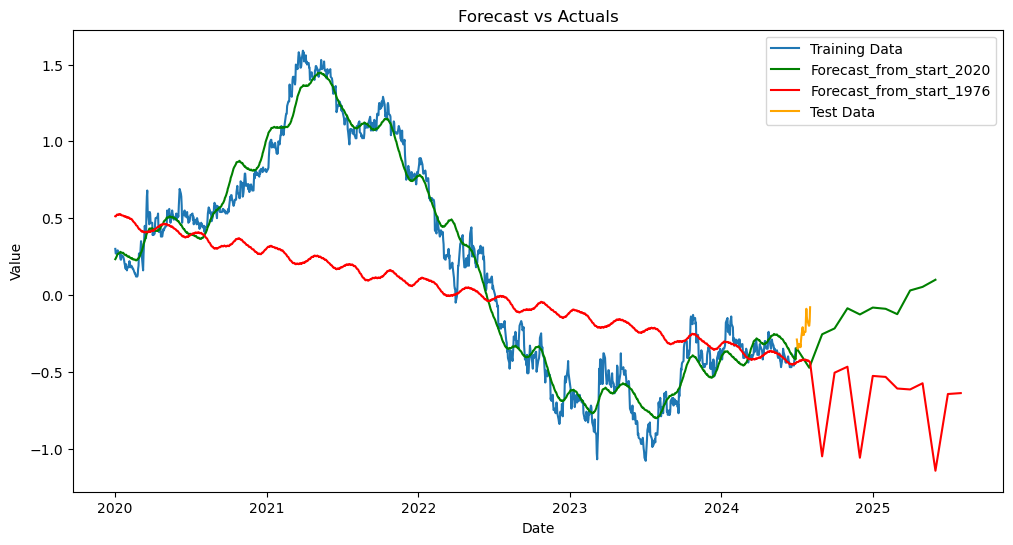

In [17]:
import matplotlib.pyplot as plt
from prophet import Prophet

train_df = data[(data['ds'] >= '2020-01-01') & (data['ds'] < '2024-07-01')]
test_df = data[data['ds'] >= '2024-07-01']

model = Prophet()
model.fit(train_df)  # Обучите модель на обучающих данных

model1 = Prophet()
model1.fit(data)  # Обучите модель на ALL данных

future = model.make_future_dataframe(periods=12, freq='M')
future1 = model1.make_future_dataframe(periods=12, freq='M')


forecast = model.predict(future)
forecast1 = model1.predict(future1)

plt.figure(figsize=(12, 6))
plt.plot(train_df[train_df['ds'] >= '2020-01-01']['ds'], train_df[train_df['ds'] >= '2020-01-01']['y'], label='Training Data')
plt.plot(forecast[forecast['ds'] >= '2020-01-01']['ds'], forecast[forecast['ds'] >= '2020-01-01']['yhat'], label='Forecast_from_start_2020', color='green')
plt.plot(forecast1[forecast1['ds'] >= '2020-01-01']['ds'], forecast1[forecast1['ds'] >= '2020-01-01']['yhat'], label='Forecast_from_start_1976', color='red')
plt.plot(test_df[test_df['ds'] >= '2022-01-01']['ds'], test_df[test_df['ds'] >= '2022-01-01']['y'], label='Test Data', color='orange')
plt.legend()
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

<h1 style="margin-left: 20px; color:blue">5. Evaluate the machine learning model </h1>

In [19]:
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

  0%|          | 0/4 [00:00<?, ?it/s]

20:42:52 - cmdstanpy - INFO - Chain [1] start processing
20:42:52 - cmdstanpy - INFO - Chain [1] done processing
20:42:52 - cmdstanpy - INFO - Chain [1] start processing
20:42:52 - cmdstanpy - INFO - Chain [1] done processing
20:42:53 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing
20:42:53 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.66
Mean Squared Error: 0.61
Root Mean Squared Error: 0.78
